In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import scipy
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from IPython import display

# Models

## Gaussian Model

Formulation of the gradient of the multivariate normal distribution comes from the [Matrix Cookbook](http://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf).

In [14]:
def get_multivariate_normal(mean, covariance, coord, height=None):
    dist = multivariate_normal(mean, covariance)
    z = dist.pdf(coord)
    if height is not None and np.max(z) != 0:
        z = (z / np.max(z)) * height
    return z

In [30]:
class Gaussian(object):
    
    def __init__(self):
        self.mu_x = 1
        self.mu_y = 1
        self.sigma_xx = 1
        self.sigma_xy = 0.01
        self.sigma_yy = 1
    
    def featurize(self, X):
        return X

    @property
    def initialized(self):
        return self.mu_x is not None
    
    def fit(self, X, predictions):  
        
        feat = self.featurize(X)
        
        # Objective function: minimize the sum square distance between the observed values
        # and the predictions by the current multi-variate Gaussian
        def objective(p, X, y):

            # If the covariance matrix isn't even valid, then return early with
            # a high cost.  It will be impossible to make a valid multivariate Gaussian
            # with Scipy without a positive semi-definite matrix
            nn_penalty = 0
            nn_penalty += -1 * min(0, p[2] * p[4] - p[3] * p[3])
            nn_penalty += -1 * min(0, p[2])
            if nn_penalty > 0:
                return 100 * nn_penalty

            # Compute the residuals
            mu_x, mu_y, sigma_xx, sigma_xy, sigma_yy = p
            pred = self.predict_with_params(X, mu_x, mu_y, sigma_xx, sigma_xy, sigma_yy)
            resid = y * (y - pred)  # It's most important to fit the high-ranking examples
            err = np.sum(np.square(np.abs(resid)))
            return err 
        
        # We won't define the Jacobian with respect to each of the parameters for now, but for
        # our first stab will just let scipy perform numerical approximation of the Jacobian.
        
        # Constraints to make sure that the covariance matrix is positive semi-definite
        # (According to Sylvester's criterion)
        cons = ({
            # Principal 2x2 minor must have a non-negative determinant
            'type': 'ineq',
            'fun': lambda p: np.array([p[2] * p[4] - p[3] * p[3]]),
            'jac': lambda p: np.array([0, 0, p[4], -2 * p[3], p[2]]),
        }, {
            # Principal 1x1 minor muxt have a non-negative determinant
            'type': 'ineq',
            'fun': lambda p: np.array([p[2]]),
            'jac': lambda p: np.array([0, 0, 1, 0, 0])
        })
        
        # Optimize!
        p0 = self.mu_x, self.mu_y, self.sigma_xx, self.sigma_xy, self.sigma_yy
        res = scipy.optimize.minimize(objective, p0, args=(feat, y,),
            constraints=cons, method='SLSQP')
        self.mu_x, self.mu_y, self.sigma_xx, self.sigma_xy, self.sigma_yy = res.x
        
    def _covariance(self):
        return np.array([
            [self.sigma_xx, self.sigma_xy],
            [self.sigma_xy, self.sigma_yy]
        ])
    
    def predict_with_params(self, X, mu_x, mu_y, sigma_xx, sigma_xy, sigma_yy):
        heights = get_multivariate_normal(
            (mu_x, mu_y),
            np.array([[sigma_xx, sigma_xy], [sigma_xy, sigma_yy]]), 
            X, height=5)
        return heights
    
    def predict(self, X):
        return self.predict_with_params(X, self.mu_x, self.mu_y, self.sigma_xx, self.sigma_xy, self.sigma_yy)
    
    def gradient(self, point):
        x, y = point
        inv_cov_matrix = np.linalg.inv(self._covariance())
        pred = self.predict(np.array([point]))
        distance = np.array([[x - self.mu_x], [y - self.mu_y]])
        gradient = -1 * pred * inv_cov_matrix.dot(distance)
        return gradient.T[0]

Gradient computed as follows:
$\nabla(a_1x + a_2y + a_3x^2 + a_4y^2 + a_5xy + a_6) = $
$\begin{bmatrix} a_1 + 2a_3x + a_5y \\ a_2 + 2a_4y + a_5x \end{bmatrix}$

Produce heavy penalty for non-negative coefficients for parabaloid terms to make sure that parabaloids only face downward.

$J(\theta) = \left\| y - Ax \right\| + max(0, Cx_{x^2}) + max(0, Cx_{y^2}) $

In [4]:
class LeastSquares(object):
    
    def __init__(self):
        self.coeff = None 
    
    def featurize(self, X):
        features = []
        for row in X:
            x, y = row
            features.append([x, y, x * x, y * y, 1])
        return np.array(features)

    @property
    def initialized(self):
        return self.coeff is not None
    
    def fit(self, X, predictions):  
        
        POSITIVE_PARABALOID_PENALTY = 100
        
        def residuals(p, y, X):
            p_xx = p[2]
            p_yy = p[3]
            err = np.abs(y - X.dot(p))
            err[0] = err[0] + \
                max(0, POSITIVE_PARABALOID_PENALTY * p_xx) + \
                max(0, POSITIVE_PARABALOID_PENALTY * p_yy)
            return err
        
        feat = self.featurize(X)
        p0 = [1, 1, 1, 1, 1]
        self.coeff = scipy.optimize.leastsq(residuals, p0, args=(predictions, feat))[0]
    
    def predict(self, X):
        predictions = []
        feat = self.featurize(X)
        for row in feat:
            prediction = row.dot(self.coeff)
            predictions.append(prediction)
        return np.array(predictions) 
    
    def gradient(self, point):
        x, y = point
        return np.array([
            self.coeff[0] + (2 * self.coeff[2] * x),
            self.coeff[1] + (2 * self.coeff[3] * y),
        ])  

In [5]:
def add_element(np_array, el):
    list_ = np_array.tolist()
    list_.append(el)
    return np.array(list_)

#### Plotting / Visualization / User Input

In [20]:
def plot_contour(x, y, z, levels=[0, 1, 2, 3, 4, 5]):
    cs = contour(x, y, z, colors='b', levels=levels)
    clabel(cs, fmt="%d")

In [6]:
def plot_gaussian():
    x_gauss, y_gauss = np.mgrid[-1:1:.02, -1:1:.02]
    coord = np.empty(x_gauss.shape + (2,))
    coord[:, :, 0] = x_gauss
    coord[:, :, 1] = y_gauss
    z = get_multivariate_normal((0.5, 0.5), .4, coord, height=5)
    plot_contour(x_gauss, y_gauss, z)    

In [7]:
def plot_model(model):
    coord_grid = np.mgrid[-1:1:.02,-1:1:.02]
    model_x, model_y = coord_grid
    model_x_flat = model_x.flatten()
    model_y_flat = model_y.flatten()
    model_coord = np.array(zip(model_x_flat, model_y_flat))
    model_pred = model.predict(model_coord)
    contour(model_x, model_y, model_pred.reshape((100,100)))

In [8]:
def query_rank(index, model):

    # Show the point queried on the current plot
    fig = figure(figsize=(8, 3))
    subplot(1, 2, 1)
    if model.initialized:
        plot_model(model)
    title("Current model")
    
    subplot(1, 2, 2)
    plot_gaussian()
    hold('on')
    plot(X[index][0], X[index][1], 'rx', markersize=20)
    display.display(gcf())
    title("Give a rank to the X")

    # Get rank for the new input point
    print "Enter rank (1-5):",
    return float(raw_input())

### Running the Algorithm

Start out the algorithm with the four points in the corner

In [31]:
X = np.array([
    [-1, -1],
    [1, -1],
    [-1, 1],
    [1, 1],
    [0, 0],
])

In [32]:
y = np.empty(0)

In [33]:
model = Gaussian()

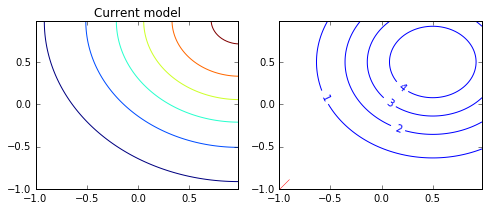

Enter rank (1-5):1


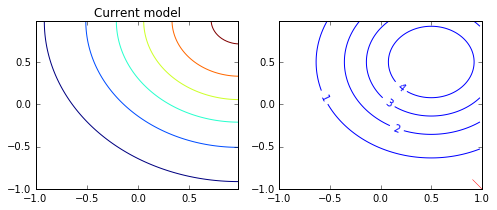

 Enter rank (1-5):1


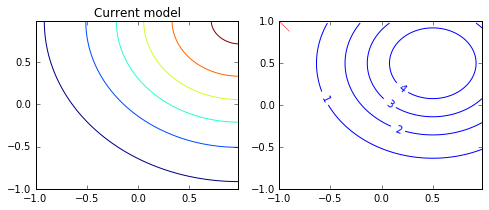

 Enter rank (1-5):1


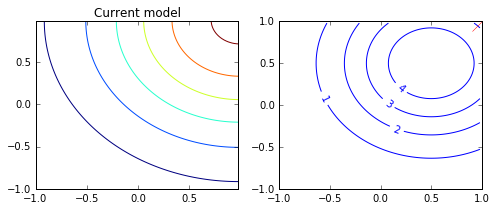

 Enter rank (1-5):1


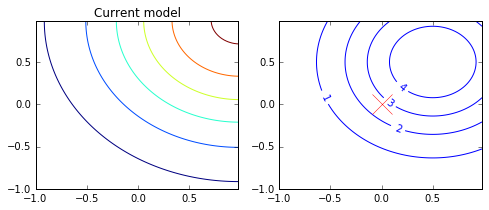

 Enter rank (1-5):2
 Gradient direction: [ 0.70602992  0.70818201]


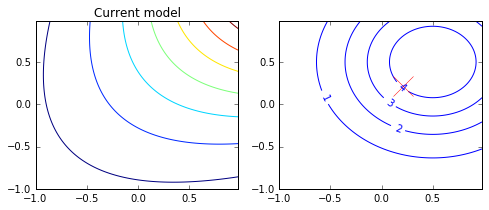

Enter rank (1-5):4
 Gradient direction: [ 0.70175844  0.71241497]


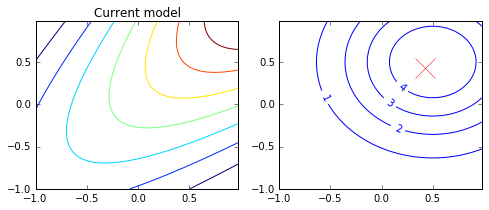

Enter rank (1-5):

In [ ]:
STEP = .3  # Determined by what seems like a small but significant step without causing thrashing
ITERATIONS = 20
current_x = np.array([0, 0])

for i in range(0, ITERATIONS):
    
    # Get values for every unlabeled x-point
    for xi in range(0, X.shape[0]):
        
        if xi >= y.shape[0]:
            newy = query_rank(xi, model)
            y = add_element(y, newy)
    
    model.fit(X, y)
    grad = model.gradient(current_x)
    unit_grad = grad / np.linalg.norm(grad) if np.linalg.norm(grad) > 0 else grad
    print "Gradient direction:", unit_grad
    
    # At most, move a unit away.  In the case of a small gradient, move only by that gradient
    stepped_grad = unit_grad if np.linalg.norm(grad) > 1 else grad
    current_x = current_x + stepped_grad * STEP
    X = add_element(X, current_x)